# Capstone Regression Project

Name: Dorianny Molina-Codella

## Business Understanding


The company we will be making the following analysis for, is a famous Realtor Group. They want us to build a model that helps them to easily estimate the price on the properties their clients want to sell. Also to give a better understanding, if there's actions they can take, to make the property more valuable, and to find which values in the model are the ones responsible for settling a better price. We will be analyzing data from houses sold from years 2021 and 2022 in King County, Washington, and from then we'll be building our complete model.

## Data Understanding

Our data contains information about the houses that have been sold between years 2021 and 2022 in King County. When cleaning the data, we found out that there were other zip codes outside King County but we had to stick only to work with the houses sold in King County because it is easier and better to analyze if using properties from one county that multiple and not in the same proportion. It could lead to an inaccurate model.

## Data Preparation

### Loading the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
KC_df = pd.read_csv('./data/kc_house_data.csv')

### Data Exploration

In [3]:
KC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

For our database we have 30.155 entries and 25 columns refering to important information about houses sold in the years 2021 to 2022. Luckyly our data base have missing values only two columns which are heat_source and sewer_system so we have a really neat database to start working with.

### Data Cleaning

First of all, we'll start dropping all the columns we won't be using and the ones that are not important according to the model we're building.

In [4]:
#Drop ID column and numerical columns with no importance for the modeling/records
KC_df.drop(columns=['id', 'lat', 'long'], inplace=True)

In [5]:
#Only year from date cleaning

KC_df['yr_sold'] = KC_df['date'].map(lambda x: '{}'.format(x[-4:]))

KC_df['yr_sold'] = KC_df['yr_sold'].astype(int)

In [6]:
KC_df['yr_old'] = np.where(KC_df['yr_renovated'] != 0, KC_df.yr_sold.apply(lambda x: x) - KC_df['yr_renovated'],
                          KC_df['yr_sold'].apply(lambda x: x) - KC_df['yr_built'])

In [7]:
#Zip code cleaning

KC_df['Zip_code'] = KC_df['address'].map(lambda x: '{}'.format(x[-20:-15]))

KC_df['Zip_code'] = KC_df['Zip_code'].astype(str)

In [8]:
# Now we're filtering by Zip Codes,and we're gonna use the Top 50 so our model won't be so charged.

KC_Zip =  KC_df['Zip_code'].value_counts().sort_values(ascending=False).head(50)

In [9]:
KC_df['Zip_code'].value_counts()

98042    992
98038    858
98115    761
98103    761
98117    748
        ... 
62204      1
68862      1
85207      1
99202      1
34470      1
Name: Zip_code, Length: 399, dtype: int64

In [10]:
KC_Zip.index

Index(['98042', '98038', '98115', '98103', '98117', '98023', '98034', '98058',
       '98133', '98001', '98092', '98033', '98118', '98059', '98052', '98106',
       '98031', '98006', '98056', '98155', '98125', '98045', '98022', '98107',
       '98003', '98126', '98122', '98144', '98146', '98074', '98198', '98075',
       '98199', '98008', '98053', '98116', '98168', '98178', '98027', '98030',
       '98002', '98040', '98028', '98166', '98072', '98105', '98004', '98029',
       '98010', '98112'],
      dtype='object')

In [11]:
KC_Zip_list = ['98042', '98038', '98115', '98103', '98117', '98023', '98034', '98058',
       '98133', '98001', '98092', '98033', '98118', '98059', '98052', '98106',
       '98031', '98006', '98056', '98155', '98125', '98045', '98022', '98107',
       '98003', '98126', '98122', '98144', '98146', '98074', '98198', '98075',
       '98199', '98008', '98053', '98116', '98168', '98178', '98027', '98030',
       '98002', '98040', '98028', '98166', '98072', '98105', '98004', '98029',
       '98010', '98112']

In [12]:
KC_Zip_df = KC_df[KC_df['Zip_code'].isin(KC_Zip_list)]

In [13]:
len(KC_Zip_df['Zip_code'].value_counts())

50

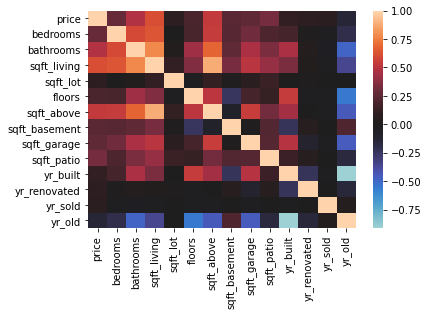

In [14]:
sns.heatmap(KC_Zip_df.corr(), center=0);

The last heatmap was used to find the variables with the correlations we can take into account for building the model, being the ones that are more correlated to the price, the variables that are going to help us to build a better model.

## Modeling

### Baseline Model

For our modeling, we will be using the following variables:

- bedrooms: Number of bedrooms there are in the property
- bathrooms: Number of bathrooms there are in the property
- Sqft_living: Square footage of living space in the home
- Sqft_patio: Square footage of outdoor porch or deck space 
- Yr_old: The last year it was sold minus the last year a modification was made.
- Zip_Code_number: Zip code the house its located.
    

In [15]:
len(KC_Zip_df['price'])

24869

In [16]:
y = KC_Zip_df['price']
X_Zip = KC_Zip_df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_patio', 'Zip_code', 'yr_built', 'yr_old']]
X_Zip = pd.get_dummies(X_Zip, columns = ['Zip_code']) 
X_Zip = X_Zip.drop(['Zip_code_98042'], axis=1)

In [17]:
model = sm.OLS(y, sm.add_constant(X_Zip))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     647.3
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:45:35   Log-Likelihood:            -3.6461e+05
No. Observations:               24869   AIC:                         7.293e+05
Df Residuals:                   24813   BIC:                         7.298e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.436e+06   5.73e+05      7.

The model overall explains about 59% of the variance in the price of the properties.

Using a value of 0.05 for the standard alpha we got the following results:

Coefficients for variables: `bedrooms` and `bathrooms` are statistically significant as they have a P-value < 0.05
Coefficients for `yr_old`, `yr_built`, `sqft_living` and `sqft_patio` are statistically significant.
When checking the values for the `zip_codes`, there's 8 zip codes with P_values greater than 0.05, for instance, they're not statistically significant. Our Zip code in comparison with the others, is the `98042`, because it is the one, that has more properties sold in our data.

When evaluating the coefficients, we could say that for each additional `bathroom` the `price` increases 52.300 dollars.
For every additional square ft in the `living area`, there's an increase in sale `price` of 480 dollars, for every additional square ft in `patio`, it will be an increase of 232 dollars in sale `price`. When speaking about the years, the age the house has, when it is greater, it decreases the house sale price by 1108 dollars per year. When speaking of `zip codes`, we can assume for our model, that zip code 98042 it's one of the cheapest of the 50 selected for the model, we only have 4 `zip codes` which can decrease the sale `price`, in difference with the zip code 98042.

We can observe how for our `bedroom` variable, we have a negative coefficient, which we can say it's absurd. Because that implies that for each additional `bedroom` the property will cost 11.230 dollars less, but what we actually can conclude about it, that even though it is statistically significant, the coefficient itself can't give us relevant information.

### Model Iteration

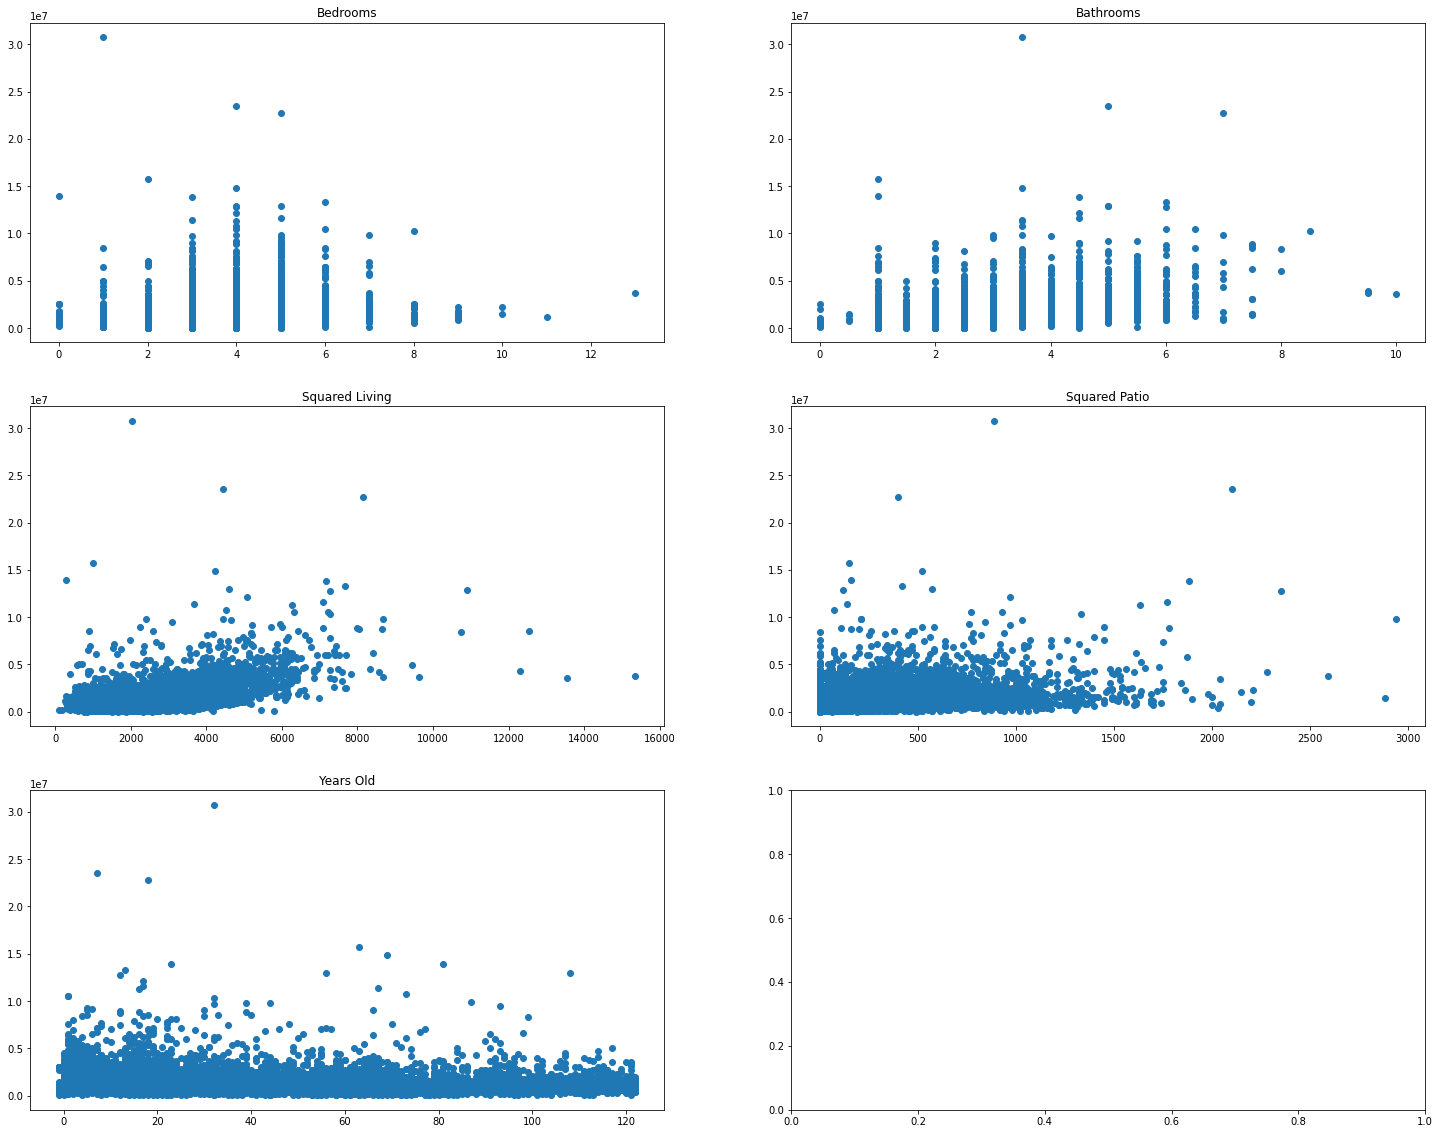

In [18]:
#plt.scatter(ames_subset.LotArea, ames_subset.SalePrice);
figure, axis = plt.subplots(3, 2, figsize=(25,20))
#Lot Area
axis[0, 0].scatter(x=KC_Zip_df.bedrooms, y=KC_Zip_df.price)
axis[0, 0].set_title("Bedrooms")
#1stFlrSF
axis[0, 1].scatter(x=KC_Zip_df.bathrooms, y=KC_Zip_df.price)
axis[0, 1].set_title("Bathrooms")
#GrLivArea
axis[1, 0].scatter(x=KC_Zip_df.sqft_living, y=KC_Zip_df.price)
axis[1, 0].set_title("Squared Living")
# Patio
axis[1, 1].scatter(x=KC_Zip_df.sqft_patio, y=KC_Zip_df.price)
axis[1, 1].set_title("Squared Patio")
# 
axis[2, 0].scatter(x=KC_Zip_df.yr_old, y=KC_Zip_df.price)
axis[2, 0].set_title("Years Old")
# Combine all the operations and display
plt.show()

In [19]:
print(KC_Zip_df["price"].describe())

count    2.486900e+04
mean     1.100994e+06
std      8.794902e+05
min      2.756300e+04
25%      6.400000e+05
50%      8.550000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64


In [20]:
KC_Zip_df["price"].max()

30750000.0

In [21]:
(KC_Zip_df["price"] > 1800000).value_counts()

False    21935
True      2934
Name: price, dtype: int64

We're going to set our outlier to properties with prices above 1.3million

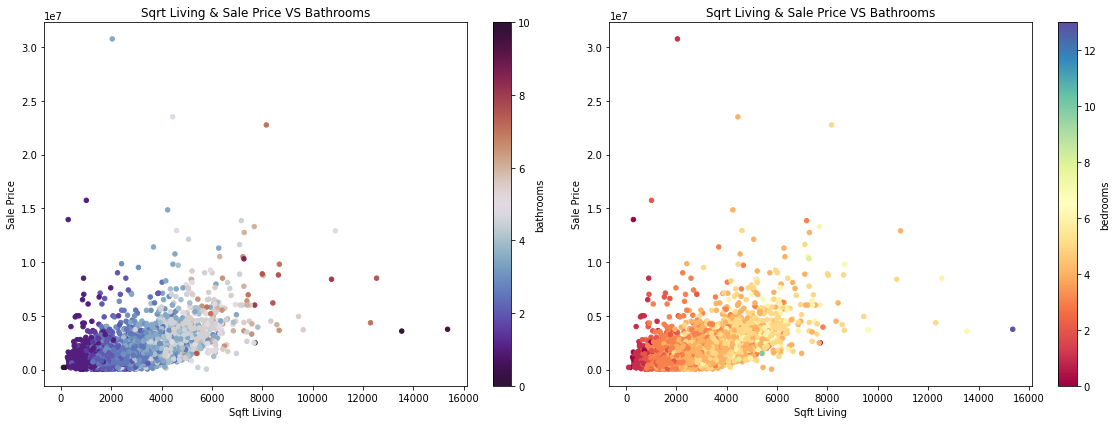

In [22]:
fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

KC_Zip_df.plot.scatter(x="sqft_living", y="price", c="bathrooms", cmap="twilight_shifted", ax=ax1)

KC_Zip_df.plot.scatter(x="sqft_living", y="price", c="bedrooms", cmap="Spectral", ax=ax2)

ax1.set_xlabel('Sqft Living')
ax1.set_ylabel('Sale Price')
ax1.set_title('Sqrt Living & Sale Price VS Bathrooms')

ax2.set_xlabel('Sqft Living')
ax2.set_ylabel('Sale Price')
ax2.set_title('Sqrt Living & Sale Price VS Bathrooms')


fig1.tight_layout();

In [23]:
# Remove some outliers and centering sqrt_living and sqrt_patio to make the analysis more intuitive

KC_int_df = KC_Zip_df[KC_Zip_df["price"] < 7000000]

KC_int_df = KC_int_df[KC_int_df["sqft_living"] < 8000]

KC_int_df = KC_int_df[KC_int_df["sqft_patio"] < 2000]

KC_int_df['Living_mean'] = KC_int_df['sqft_living'] - KC_int_df['sqft_living'].mean()

KC_int_df['Patio_mean'] = KC_int_df['sqft_patio'] - KC_int_df['sqft_patio'].mean()

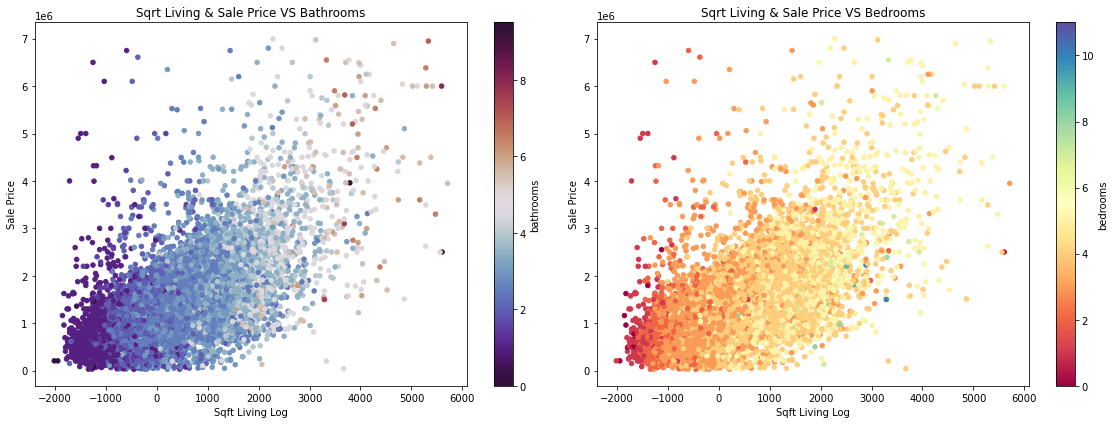

In [24]:
fig2, (ax3, ax4) = plt.subplots(ncols=2, figsize=(16,6))

KC_int_df.plot.scatter(x="Living_mean", y="price", c="bathrooms", cmap="twilight_shifted", ax=ax3)

KC_int_df.plot.scatter(x="Living_mean", y="price", c="bedrooms", cmap="Spectral", ax=ax4)

ax3.set_xlabel('Sqft Living Log')
ax3.set_ylabel('Sale Price')
ax3.set_title('Sqrt Living & Sale Price VS Bathrooms')

ax4.set_xlabel('Sqft Living Log')
ax4.set_ylabel('Sale Price')
ax4.set_title('Sqrt Living & Sale Price VS Bedrooms')

fig2.tight_layout();

We did a few transformations for the data used, so we could get data without outliers and with our `sqft_living` and `sqft_patio` columns centered. The objective of these graphs was to show the interaction we can achieve : first with `sqft_living` and the number of  `  bathrooms `   in the properties, and the interaction between `sqft_living` and the number of `  bedrooms `. For the `bathrooms ` interaction, we can observe on our graph, that for the below average on `sqft_living` , there was a number of 2 or less `bathrooms`, when having an average of `sqft_living`, the range varies from 2 to 4, being the 2+ bathrooms the more common. We can observe that when the `sqft_living` increases, so does the number of bathrooms.

For the second graph, we can observe how, for the below average `sqft_living` , the number of  ` bedrooms `   stays between 4 and less, and when the `sqft_living` increases, it does in the number of  `bedrooms`   but in a minor proportion. Both graphics will give us a very good interaction that we'll include on our model.

In [25]:
# Select relevant numeric features and center them

KC_int_df["Living_x_Bedrooms"] = KC_int_df["Living_mean"] * KC_int_df["bedrooms"]

KC_int_df["Living_x_Bathrooms"] = KC_int_df["Living_mean"] * KC_int_df["bathrooms"]

### Final Model

In [26]:
X_int = KC_int_df[['bedrooms', 'bathrooms', 'Zip_code', 'yr_built', 'yr_old', 
                   'Patio_mean', 'Living_mean', 'Living_x_Bedrooms', "Living_x_Bathrooms"]]
X_int = pd.get_dummies(X_int, columns = ['Zip_code']) 

X_int = X_int.drop(['Zip_code_98042'], axis=1)

## Regression Results

In [27]:
int_model = sm.OLS(KC_int_df['price'], sm.add_constant(X_int))
int_results = int_model.fit()
print(int_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1025.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:45:38   Log-Likelihood:            -3.5429e+05
No. Observations:               24783   AIC:                         7.087e+05
Df Residuals:                   24725   BIC:                         7.092e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.076e+06   3.99

We can observe with our iterated model, that the model represents now even more the variance of the price.

Our model represents the 70% of the variance of the price. Having an intercept of 4.076.000 but we're having a huge deviation standard, this is due to the enormous dispersion we have with the price. If we get a house, with the average in all the variables and with the zip code 98042 that will be the average price. Our model will be more precise when adding the data for the houses, instead of using the 0, which for our case could be interpreted as a property with 0 bedrooms, bathrooms, 0 square ft in the lot, so it is representative when evaluating the other variables.

The coefficient for bathrooms is 23.200, which means that for a home with average patio and living square ft the price will increase in 23.200 dollars in the sale price.

The coefficient for Patio_mean is 145, which means that for a home with average patio and living square ft the price will increase in 145 dollars when increasing square ft in patio.

The coefficient for Living_mean is 246, which means that for a property with average patio and living square ft, the price will increase to 246 dollars in the sale price.

The coefficient for Living_x_Bedrooms is about -18. This means that:

For each additional square foot of living, there will be an decrease of about \$246 + (-20 x Number of bedrooms) in the sale price.

For each additional bedroom on the property, there will be a decrease of about \$47.330 + (-20 x sqft_living) in the sale price.

The coefficient for Living_x_Bathrooms is about 82. This means that:

For each additional square foot of living, there will be an increase of about \$246 + (82 x Number of bathrooms) in the sale price.

For each additional bathroom in the property, there will be an increase of about \$23.200 + (246 x sqft_living) in the sale price.

In [28]:
def final_model(bedrooms, bathrooms, year_built, age, Patio_size, Living_size, ZipCode):
    
    if type(bedrooms + bathrooms + year_built + age + Patio_size + Living_size) == int or float:
        Constant = 4.076e+06
        X_bedrooms = -4.733e+04 * bedrooms
        X_bathrooms = 2.32e+04 * bathrooms
        X_year_built = -1650.9479 * year_built
        X_age = -1327.9248 * age
        X_Patio = 145.0182 * (Patio_size - KC_int_df['sqft_patio'].mean())
        X_living = 246.4098 * (Living_size - KC_int_df['sqft_living'].mean())
        Living_x_bed = 246.4098 + (-19.6881 * bedrooms)
        Living_x_bath = 246.4098 + (82.3149 * bathrooms)
        
        if ZipCode == 98042:      
            price = 4.076e+06 + X_bedrooms + X_bathrooms + X_year_built +  X_age + X_Patio + X_living
        else:
            price = 'Zip_code Error'
    else:
        price = 'Please insert a valid number' 
    return price

In [31]:
print(final_model(5,2.5,2002,19,160,2640,98042))

690754.0193804384


In [30]:
KC_df.loc[KC_df['Zip_code'] == '98042']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,yr_sold,yr_old,Zip_code
93,6/21/2021,742000.0,4,3.0,2190,40500,1.0,NO,NO,NO,...,1250,1250,570,510,1980,0,"19030 Southeast 320th Street, Kent, Washington...",2021,41,98042
99,7/16/2021,700000.0,5,2.5,2640,7882,2.0,NO,NO,NO,...,2640,0,600,160,2002,0,"28305 143rd Place Southeast, Kent, Washington ...",2021,19,98042
114,7/30/2021,410000.0,3,1.0,920,4770,1.0,NO,NO,NO,...,920,0,400,0,1969,0,"19406 Southeast 265th Street, Covington, Washi...",2021,52,98042
237,12/7/2021,566000.0,4,2.0,1540,7140,1.0,NO,YES,NO,...,770,770,700,160,1970,0,"25513 151st Place Southeast, Covington, Washin...",2021,51,98042
265,10/5/2021,560000.0,3,2.5,1660,7330,2.0,NO,NO,NO,...,1660,0,570,0,1994,0,"27004 137th Avenue Southeast, Kent, Washington...",2021,27,98042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,4/5/2022,600000.0,4,2.0,1810,7111,1.0,NO,NO,NO,...,1810,0,440,60,1981,0,"19020 Southeast 262nd Street, Covington, Washi...",2022,41,98042
30011,4/11/2022,465000.0,4,1.5,1420,5590,1.0,NO,NO,NO,...,1420,0,0,0,1968,0,"26631 190th Avenue Southeast, Covington, Washi...",2022,54,98042
30045,2/9/2022,603055.0,3,2.5,2120,4500,2.0,NO,NO,NO,...,2120,0,430,60,2022,0,"25313 174th Place Southeast, Covington, Washin...",2022,0,98042
30050,5/12/2022,854500.0,4,2.5,2290,46638,2.0,NO,NO,NO,...,2290,0,480,510,1980,0,"15620 Southeast 303rd Place, Kent, Washington ...",2022,42,98042


## Conclusion

The model built can show an minimal approximation of 70%,  from the prices we see on the original database. Right now the model we built is working with the zip code by default to show its effectiveness but, soon it will be built with the 50 zip codes used in the investigation so we can predict the value for the houses that belong to the 50 zip codes studied.

When observing the model, after applying the interactions, we could get the model to represent from 58% to 70% of the variance, so adding the interaction was a good decision that helped us to build a model closer to the property prices according to the data used. Keeping the database updated will allow us to keep the information accurate to the market price.

## Level Up: Project Enhancements

After completing the minimum project requirements, you could consider the following enhancements if you have time:

* Consider applying a linear or non-linear transformation to your features and/or target
* Investigate the linear regression assumptions for your final model
* Identify and remove outliers, then redo the analysis
* Compile the data cleaning code into a function